# Process Data

load 160k MadGraph events for $p p \to j j W^{\pm} W^{\pm}$

In [2]:
import numpy as np
import pandas as pd

from src.processing import processData

In [3]:
process_data = processData()

In [5]:
dfww = (process_data.get_events('data/jjWpmWpm_undecayed_01.csv')
        .append(process_data.get_events('data/jjWpmWpm_undecayed_02.csv'), ignore_index=True)
        .append(process_data.get_events('data/jjWpmWpm_undecayed_03.csv'), ignore_index=True))

Preview the data.

In [7]:
dfww.head()

,n_lon,e.j1,e.j2,e.W1,e.W2,pT.W1,pT.W2,pT.j1,pT.j2,eta.W1,...,phi.j1,phi.j2,mm.jj,delta_eta.jj,delta_phi.jj,mm.WW,e.WW,pT.WW,eta.WW,phi.WW
0,1,853.887756,257.352356,249.432434,2606.904785,134.747803,84.111771,257.740295,177.310089,1.038549,...,0.165793,2.785549,463.735718,0.949750,2.619756,556.902893,2856.337402,136.505936,2.288648,-2.271533
1,1,641.823181,339.917633,82.619926,1815.634644,10.870395,108.078812,313.608734,315.174683,-0.190025,...,0.364657,-2.466530,875.875916,1.737138,2.831186,509.038696,1898.254517,97.210144,-1.972227,2.074740
2,2,2500.156738,1097.197998,96.481102,2337.897949,47.110420,64.178131,223.824249,257.997192,-0.264494,...,-0.934174,2.509224,3302.680420,5.230980,2.839788,589.500000,2434.379150,79.923981,-2.086937,0.351092
3,2,892.542358,87.227493,1278.756348,188.164307,26.556881,46.456238,50.416321,71.280518,3.406688,...,-0.388047,2.660497,270.666412,2.909078,3.048545,280.986053,1466.920654,21.596445,2.333461,-0.699738
4,1,225.321259,386.506378,168.499710,293.360413,23.823366,84.840263,223.655533,119.696884,-1.322123,...,-0.003282,2.970571,454.825195,1.718473,2.973853,171.348923,461.860107,107.512222,-1.466903,-2.957911


There is definitely a class imbalance problem. Both $W$s are longitudinally polarized only about 5% of the time.

In [6]:
dfww['n_lon'].value_counts() / len(dfww)

0    0.603794
1    0.346131
2    0.050075
Name: n_lon, dtype: float64

# See how this compares to arXiv:1812.07591

Differences between the two analyses:
- They don't provide many details, so it's hard to know how exact the comparison is, but
- I have fewer events, 160k vs. 4M
- My $W$s have not been decayed
- I did not pass my events through `Pythia`
- I have more (corrleated) features than they do, hoping that will lead to faster learning

## Prepare for Machine Learning

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping

from src.keras_model import build_model

For simplicity let's make this a binary classification problem, LL vs. TT + TL  ($n_{lon} = 2$ vs. $n_{lon} < 2$).

In [15]:
y = (dfww['n_lon'] == 2)

In [10]:
X = (dfww
     .drop('n_lon', axis = 1))

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(X,
                                          y,
                                          test_size=0.2,
                                          stratify=y)

## $\Delta\phi_{jj}$

Studies of the LL fraction measurement have focused on the azimuthal angle difference between the two leading jets.

In [12]:
scaler_phijj = StandardScaler()
X_tr_phijj = (scaler_phijj
              .fit_transform(X_tr['delta_phi.jj']
                             .values
                             .reshape(-1, 1)))
X_te_phijj = (scaler_phijj
              .transform(X_te['delta_phi.jj']
                         .values
                         .reshape(-1, 1)))

log_reg_phijj = LogisticRegression(solver='liblinear')

(log_reg_phijj
 .fit(X_tr_phijj, y_tr))

probas_phijj = (log_reg_phijj
                .predict_proba(X_te_phijj))

fprs_phijj, tprs_phijj, thresholds_phijj = roc_curve(y_te, probas_phijj.T[1])
auc_phijj = roc_auc_score(y_te, probas_phijj.T[1])

## $p_T^{W1}$

Another popular variable is the leading lepton transverse momentum, $p_T^{\ell 1}$. As these $W$s have not been decayed we will use $p_T^{W1}$ instead

In [13]:
scaler_pTW1 = StandardScaler()
X_tr_pTW1 = (scaler_phijj
             .fit_transform(X_tr['pT.W1']
                            .values
                            .reshape(-1, 1)))
X_te_pTW1 = (scaler_phijj
             .transform(X_te['pT.W1']
                        .values
                        .reshape(-1, 1)))

log_reg_pTW1 = LogisticRegression(solver='liblinear')

(log_reg_pTW1
 .fit(X_tr_pTW1, y_tr))

probas_pTW1 = (log_reg_pTW1
               .predict_proba(X_te_pTW1))

fprs_pTW1, tprs_pTW1, thresholds_phijj = roc_curve(y_te, probas_pTW1.T[1])
auc_pTW1 = roc_auc_score(y_te, probas_pTW1.T[1])

## Random Forest

use instead of Decision Trees w/ AdaBoost

In [14]:
rfc = RandomForestClassifier(n_estimators=200,
                             max_depth=5)

(rfc
 .fit(X_tr, y_tr))

probas_rfc = (rfc
              .predict_proba(X_te))

fprs_rfc, tprs_rfc, thresholds_rfc = roc_curve(y_te, probas_rfc.T[1])
auc_rfc = roc_auc_score(y_te, probas_rfc.T[1])

## Deep Neural Network

use the dense architecture of 1812.07591, but with 2 hidden layers instead of 10 (still deep!). The 'particle' architecture 1812.07591 won't be used in this study.

In [16]:
scaler_dnn = StandardScaler()
X_tr_dnn = (scaler_dnn
            .fit_transform(X_tr))
X_te_dnn = (scaler_dnn
            .transform(X_te))

keras_model = build_model()
keras_model.fit(X_tr_dnn,
                y_tr,
                epochs=50,
                batch_size=50,
                verbose=1,
                callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
                validation_split=0.2)

/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """


Train on 102400 samples, validate on 25600 samples
Epoch 1/50
102400/102400 [==============================] - 12s 119us/step - loss: 0.4352 - acc: 0.8600 - val_loss: 0.2738 - val_acc: 0.9498
Epoch 2/50
102400/102400 [==============================] - 10s 102us/step - loss: 0.2243 - acc: 0.9500 - val_loss: 0.2016 - val_acc: 0.9498
Epoch 3/50
102400/102400 [==============================] - 11s 111us/step - loss: 0.1923 - acc: 0.9500 - val_loss: 0.1884 - val_acc: 0.9498
Epoch 4/50
102400/102400 [==============================] - 11s 112us/step - loss: 0.1870 - acc: 0.9500 - val_loss: 0.1860 - val_acc: 0.9498
Epoch 5/50
102400/102400 [==============================] - 10s 99us/step - loss: 0.1855 - acc: 0.9500 - val_loss: 0.1848 - val_acc: 0.9498
Epoch 6/50
102400/102400 [==============================] - 11s 105us/step - loss: 0.1843 - acc: 0.9500 - val_loss: 0.1840 - val_acc: 0.9498
Epoch 7/50
102400/102400 [==============================] - 11s 106us/step - loss: 0.1841 - acc: 0.9500 

In [19]:
probas_dnn = keras_model.predict_proba(X_te_dnn)
fprs_dnn, tprs_dnn, thresholds_dnn = roc_curve(y_te, probas_dnn)
auc_dnn = roc_auc_score(y_te, probas_dnn)

## Evaluate

### AUC

Area Under the (ROC) Curve

In [20]:
(auc_dnn, auc_rfc, auc_pTW1, auc_phijj)

(0.7711119251143321,
 0.7241756862084117,
 0.5970261345139091,
 0.6400331445519405)

1812.07591 found (0.762, 0.776, 0.666, 0.591). Our Neural Network AUC is similar to there's. Our Random Forest and $p_T^{W1}$ observable underperform. This could simply be due to having less simulated data, and in the case of the RF fewer trees. Our observable $\Delta\phi_{jj}$ outperforms 1812.07591. This is likely due to the fact that hadronization effects have not been taken into account in our study. 

### ROC Curve

Next let's plot the Receiver Operator Characteristic curves themselves.

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [22]:
def roc_comparison():
    plt.figure(1)
    
    plt.plot(np.linspace(0, 1),
             1 - np.linspace(0, 1),
             c = 'gray',
             ls = ':')
    plt.plot(tprs_phijj,
             1 - fprs_phijj,
             label = r'$\Delta\phi_{jj}$',
             c = 'g')
    plt.plot(tprs_pTW1,
             1 - fprs_pTW1,
             label = r'$p_T^{W_1}$',
             c = 'pink')
    plt.plot(tprs_dnn,
             1- fprs_dnn,
             label = 'DNN',
             c = 'b')
    plt.plot(tprs_rfc,
             1 - fprs_rfc,
             label = 'RF',
             c = 'k')
    
    plt.xlabel('True Positive Rate')
    plt.ylabel('1 - False Positive Rate')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


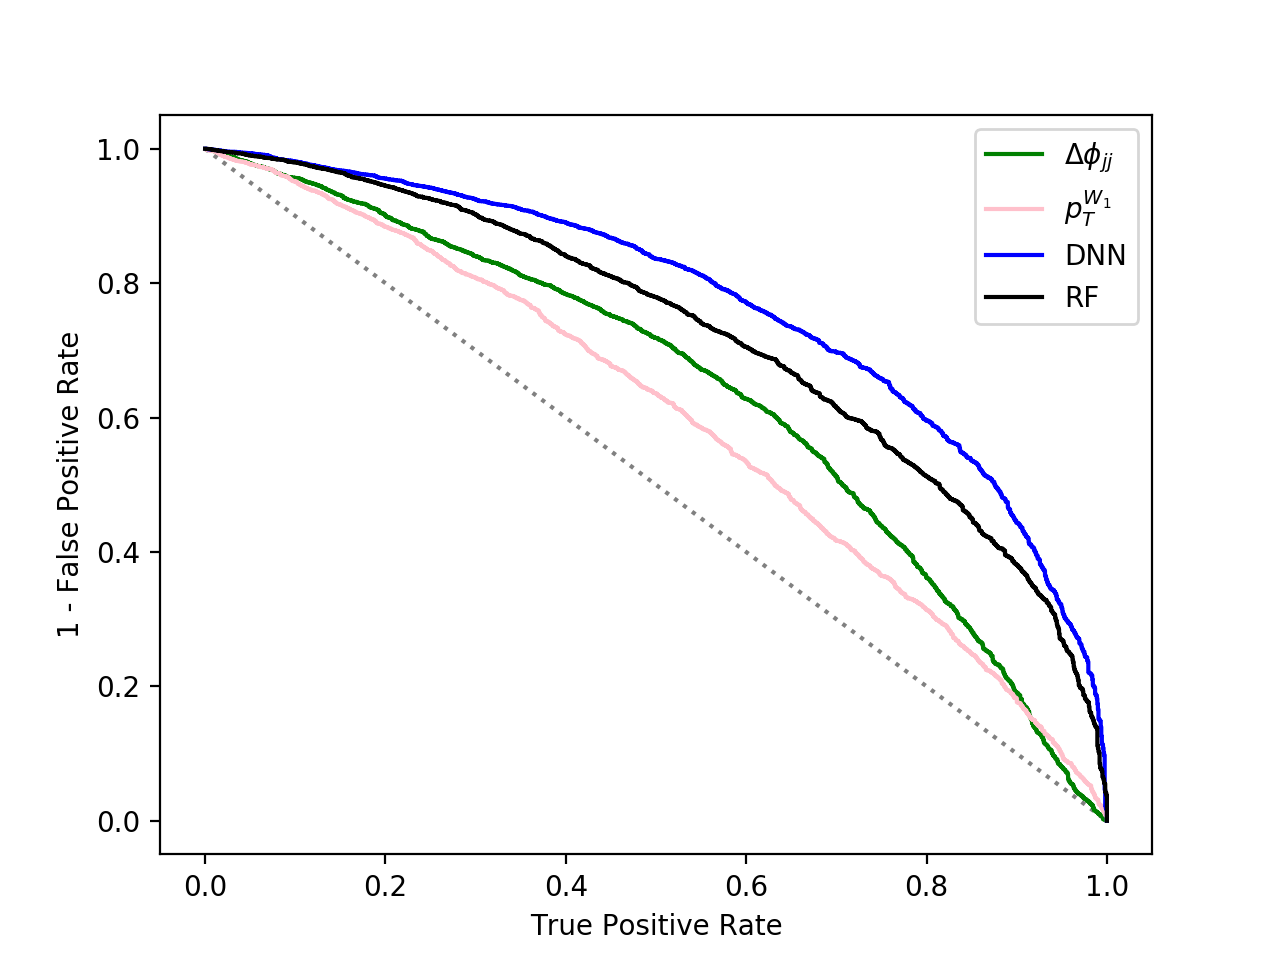

In [23]:
roc_comparison()

The ROC curve shows range of possible True and False Positive Rates depending on where discrimant threshold is set. To get a feel for what would be good choices for the thresholds we visualize kinematic distributions and ML discriminants

### Kinematic distributions and ML discriminants

In [29]:
def kin_dist():
    plt.figure(2, figsize=(10, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(dfww[dfww['n_lon'] == 2]['pT.W1'],
             bins=np.linspace(0, 1800, 36),
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(dfww[dfww['n_lon'] != 2]['pT.W1'],
             bins=np.linspace(0, 1800, 36),
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel(r'$p_T^{W1}$')
    plt.xlim(0, 500)
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.hist(dfww[dfww['n_lon'] == 2]['delta_phi.jj'],
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(dfww[dfww['n_lon'] != 2]['delta_phi.jj'],
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel(r'$\Delta\phi_{jj}$')
    plt.legend(loc=2)
    
    plt.subplot(2, 2, 3)
    plt.hist(rfc.predict_proba(X_tr_dnn[y_tr == 1]).T[1],
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(rfc.predict_proba(X_tr_dnn[y_tr == 0]).T[1],
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel('Random Forest LL probability prediction')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.hist(keras_model.predict_proba(X_tr_dnn[y_tr == 1]),
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(keras_model.predict_proba(X_tr_dnn[y_tr == 0]),
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel('DNN LL probability prediction')
    plt.legend()
    
    plt.show()

<IPython.core.display.Javascript object>


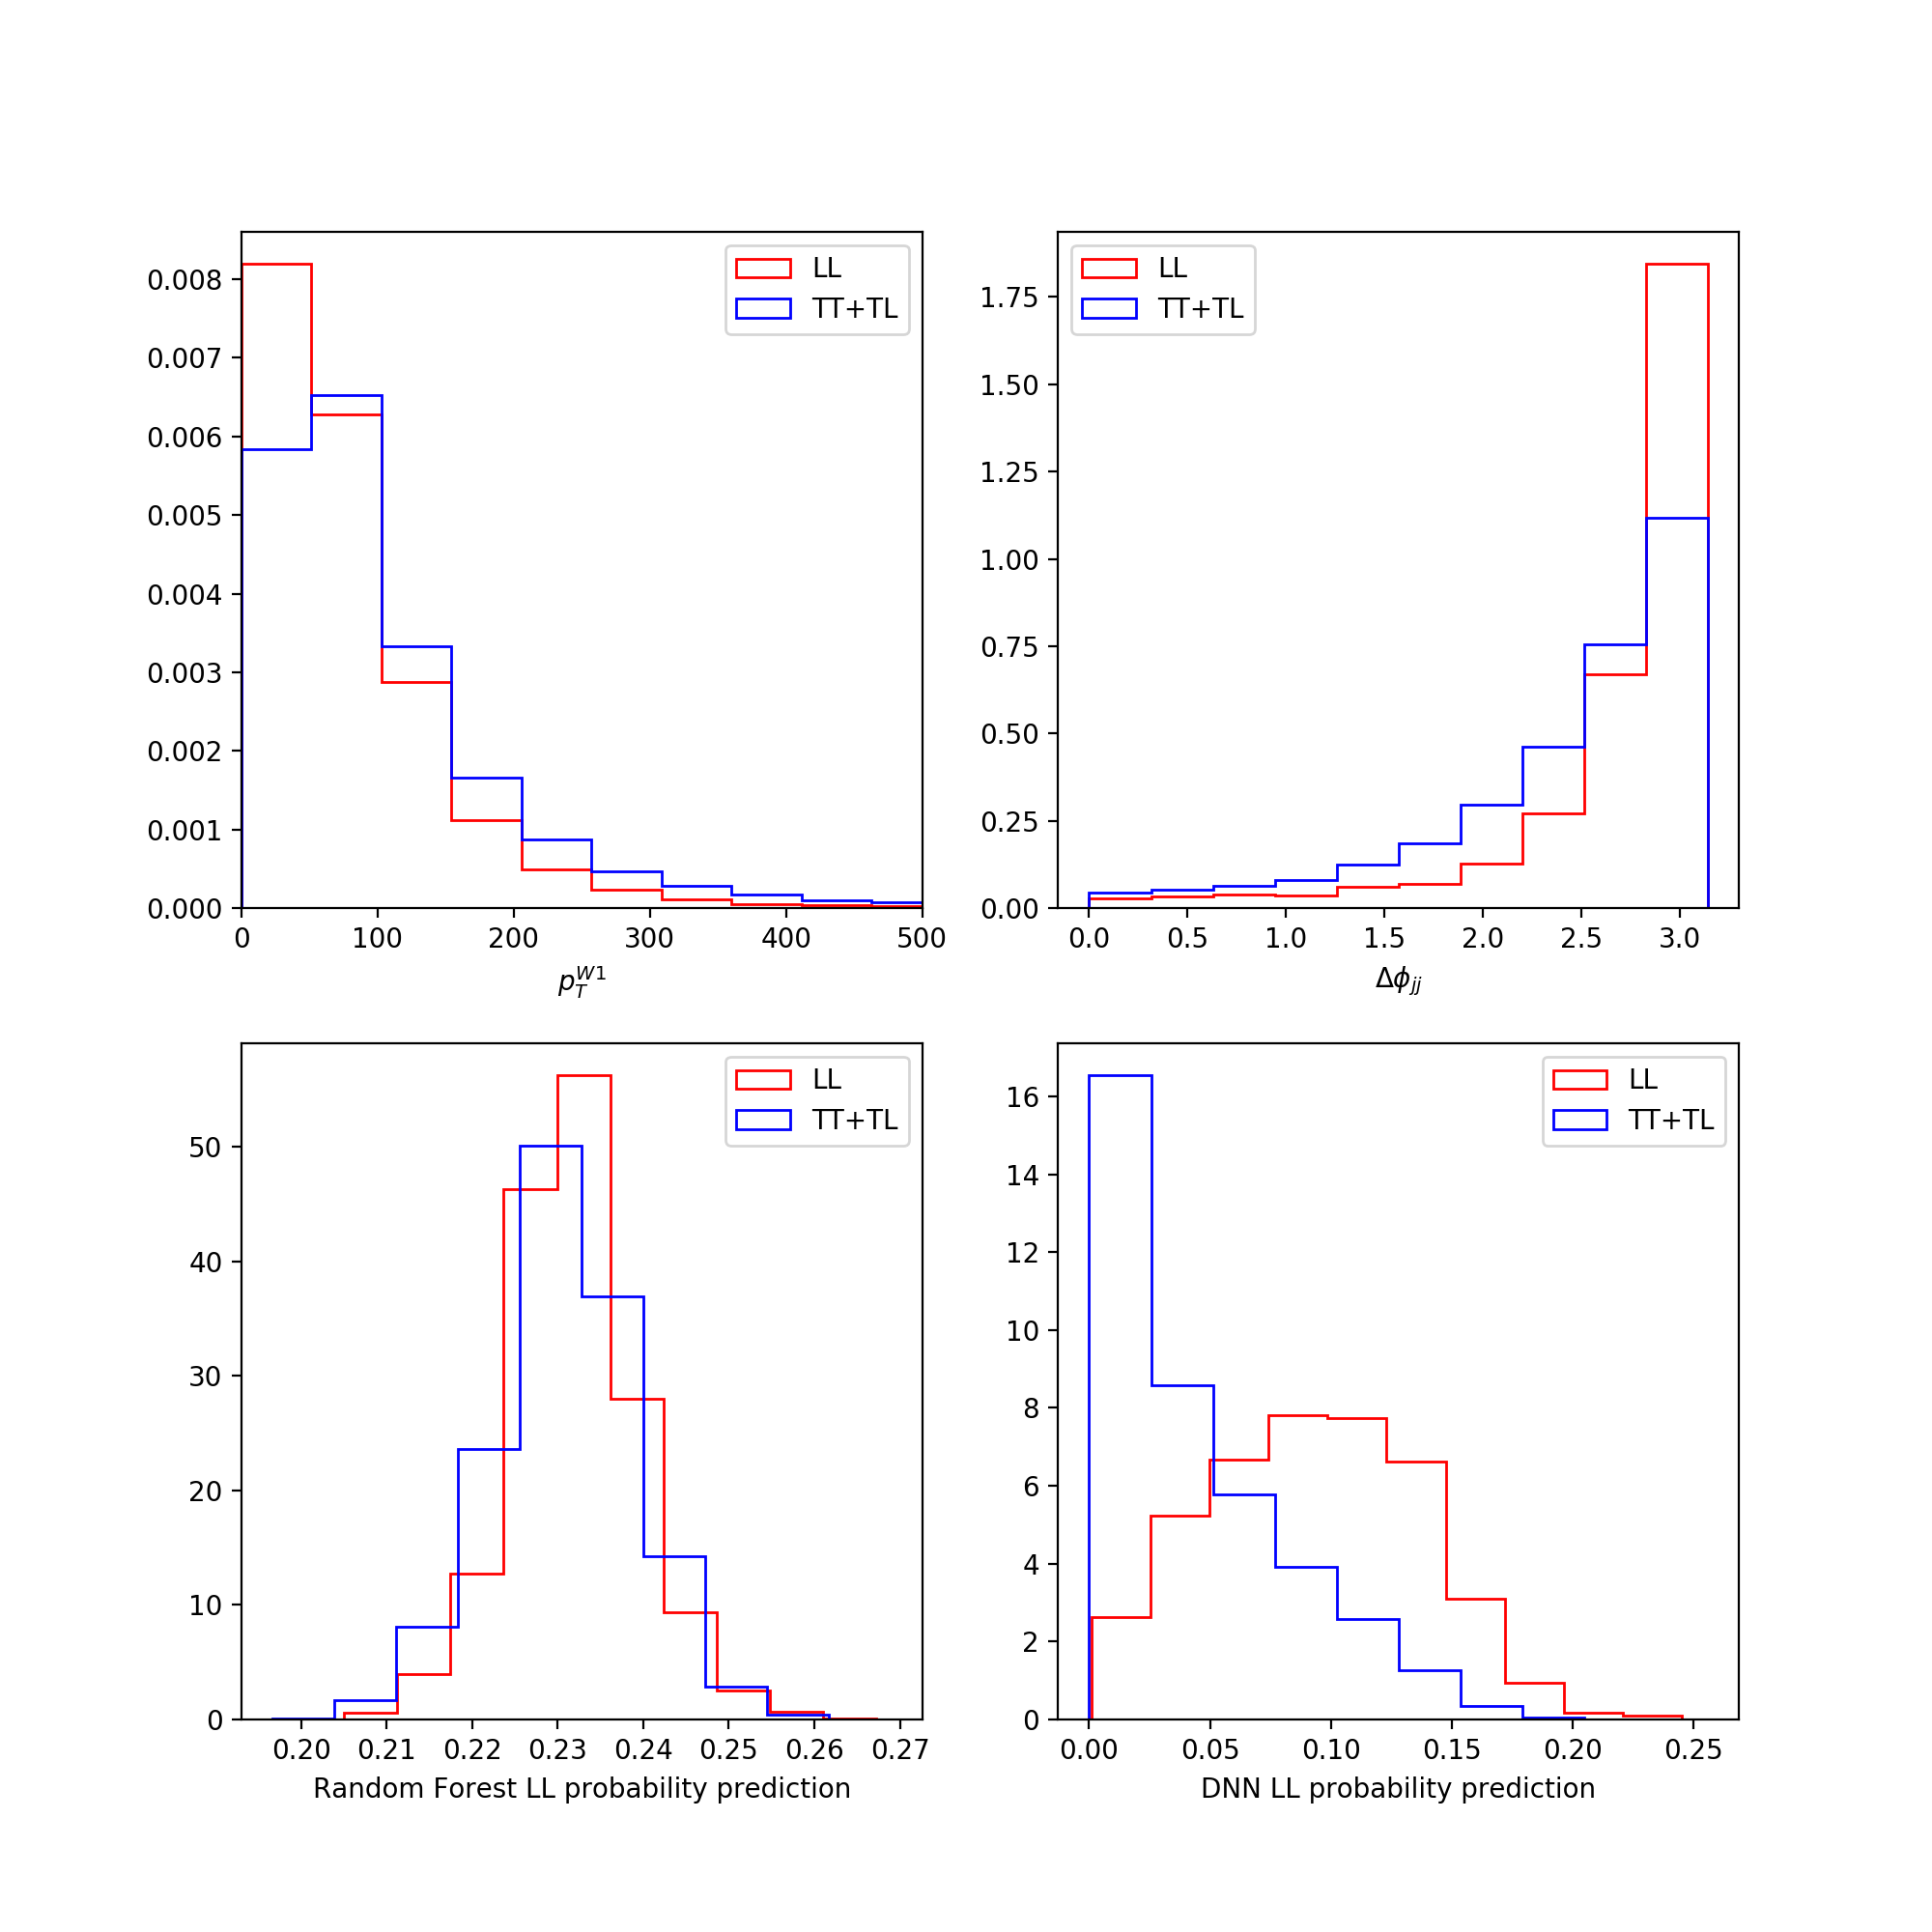

In [30]:
kin_dist()

# (Attempt to) address Class Imbalance

## Consider Different Metrics

Let's start by evaluating the models we've already trained with some different metrics. 

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

### Precision-Recall Curve

When dealing with class imbalance total accuracy is not a good metric to use as it won't be concerned with the minority class we are interested in. Precision and Recall are better metrics to use. Precision is the ratio of True Positives over the sum of True and False Positives. Recall is the ratio of True Positive over the sum of True Positives and False Negatives. Recall is equivalent to the True Positive Rate in the ROC curve. The Precision-Recall curve is better to use for class imbalance problems than the ROC curve because is more concerned with True Negatives than False Postives or Negatives.

In [32]:
precisions_dnn, recalls_dnn, threshold_dnn = precision_recall_curve(y_te, probas_dnn)
precisions_phijj, recalls_phijj, threshold_phijj = precision_recall_curve(y_te, probas_phijj.T[1])
precisions_pTW1, recalls_pTW1, threshold_pTW1 = precision_recall_curve(y_te, probas_pTW1.T[1])
precisions_rfc, recalls_rfc, threshold_rfc = precision_recall_curve(y_te, probas_rfc.T[1])

In [33]:
def PR_curve():
    plt.figure(3)
    
    f1_scores = np.linspace(0.2, 0.8, num=4)
    for f1_score in f1_scores:
        x = np.linspace(0.01, 1)
        y = f1_score * x / (2 * x - f1_score)
        plt.plot(x[y >= 0],
                 y[y >= 0],
                 color='gray',
                 alpha=0.2)
        plt.annotate(r'$f_1$={0:0.1f}'.format(f1_score), xy=(0.9, y[45] + 0.02))
    
    plt.plot(recalls_phijj,
             precisions_phijj,
             label = r'$\Delta\phi_{jj}$',
             c = 'g')
    plt.plot(recalls_pTW1,
             precisions_pTW1,
             label = r'$p_T^{W_1}$',
             c = 'pink')
    plt.plot(recalls_dnn,
             precisions_dnn,
             label = 'DNN',
             c = 'b')
    plt.plot(recalls_rfc,
             precisions_rfc,
             label = 'RF',
             c = 'k')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


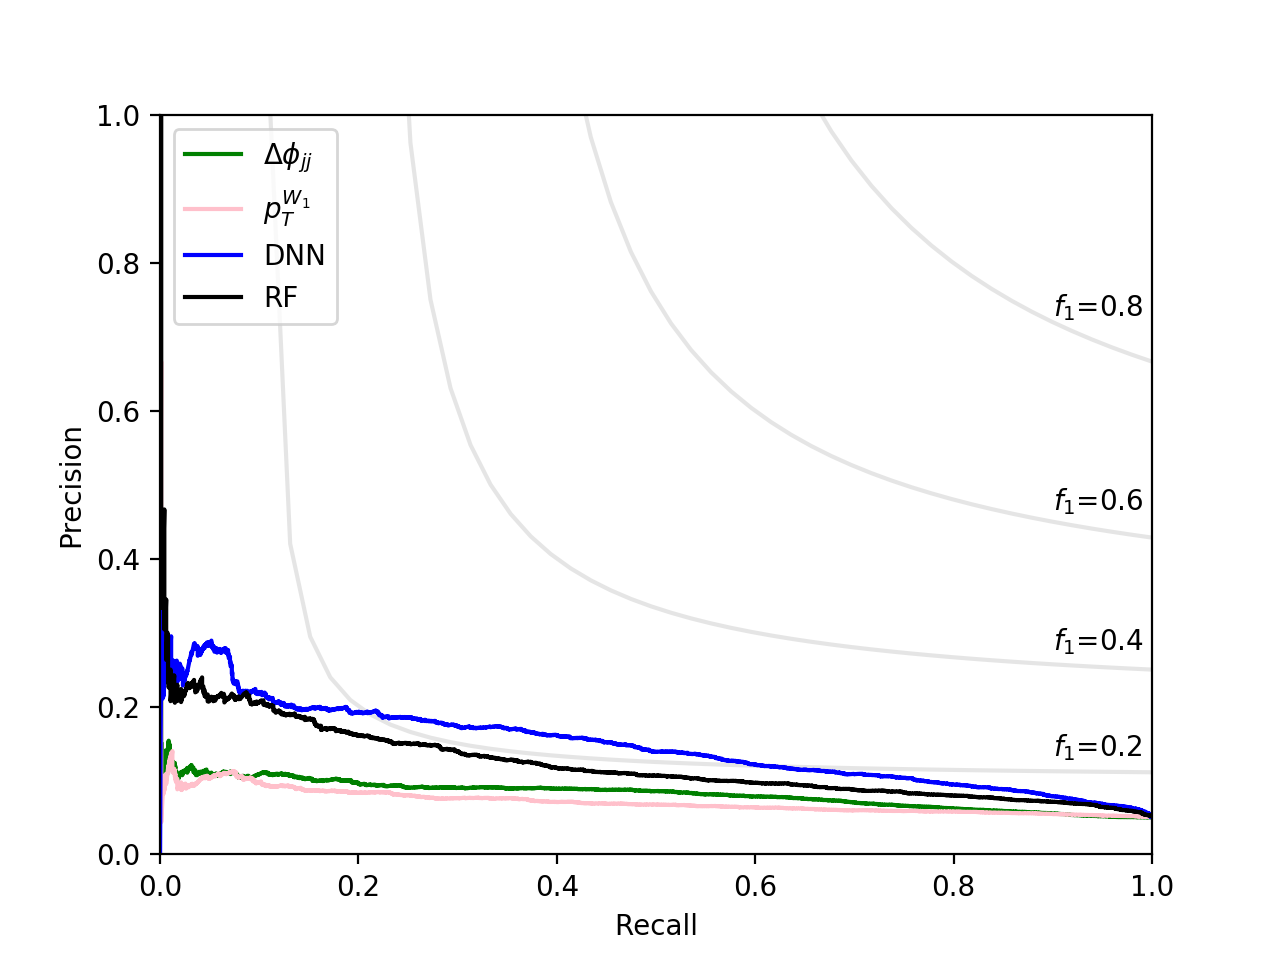

In [34]:
PR_curve()

Also plotted in Figure 3 are iso-contours of $f_1$ score. $f_1$ is defined as twice the haronic sum of precision and recall, and is useful if a single number is needed to summarize the performance of a model on a class imbalance problem.

### Confusion Matrix, Precision, Recall, $f_1$ Score

For each model let's look at how it performs when its threshold is optimized to maximize $f_1$ score.

In [35]:
def f1s(precisions, recalls):
    return 2 * precisions * recalls / (precisions + recalls)

First up is our deep neural network

In [36]:
f1_dnn = f1s(precisions_dnn[:-10], recalls_dnn[:-10])
thres_dnn = threshold_dnn[np.argmax(f1_dnn)]

In [37]:
confusion_matrix(y_te, probas_dnn > thres_dnn)

array([[27549,  2849],
       [ 1020,   582]])

In [38]:
print(classification_report(y_te, probas_dnn > thres_dnn))

              precision    recall  f1-score   support

       False       0.96      0.91      0.93     30398
        True       0.17      0.36      0.23      1602

   micro avg       0.88      0.88      0.88     32000
   macro avg       0.57      0.63      0.58     32000
weighted avg       0.92      0.88      0.90     32000



Next is the jet angular observable, which has a better recall, but lower precision and f1-score than the dnn

In [39]:
f1_phijj = f1s(precisions_phijj[:-10], recalls_phijj[:-10])
thres_phijj = threshold_phijj[np.argmax(f1_phijj)]

In [40]:
confusion_matrix(y_te, probas_phijj.T[1] > thres_phijj)

array([[22517,  7881],
       [  845,   757]])

In [41]:
print(classification_report(y_te, probas_phijj.T[1] > thres_phijj))

              precision    recall  f1-score   support

       False       0.96      0.74      0.84     30398
        True       0.09      0.47      0.15      1602

   micro avg       0.73      0.73      0.73     32000
   macro avg       0.53      0.61      0.49     32000
weighted avg       0.92      0.73      0.80     32000



3rd up is the $p_T$ of the leading $W$. This was the worst of our models

In [42]:
f1_pTW1 = f1s(precisions_pTW1[:-10], recalls_pTW1[:-10])
thres_pTW1 = threshold_pTW1[np.argmax(f1_pTW1)]

In [43]:
confusion_matrix(y_te, probas_pTW1.T[1] > thres_pTW1)

array([[23530,  6868],
       [ 1036,   566]])

In [44]:
print(classification_report(y_te, probas_pTW1.T[1] > thres_pTW1))

              precision    recall  f1-score   support

       False       0.96      0.77      0.86     30398
        True       0.08      0.35      0.13      1602

   micro avg       0.75      0.75      0.75     32000
   macro avg       0.52      0.56      0.49     32000
weighted avg       0.91      0.75      0.82     32000



Last, but not least is the random forest. The RF has the 2nd highest precision and f1-scores

In [46]:
f1_rfc = f1s(precisions_rfc[:-10], recalls_rfc[:-10])
thres_rfc = threshold_rfc[np.argmax(f1_rfc)]

In [47]:
confusion_matrix(y_te, probas_rfc.T[1] > thres_rfc)

array([[27813,  2585],
       [ 1154,   448]])

In [48]:
print(classification_report(y_te, probas_rfc.T[1] > thres_rfc))

              precision    recall  f1-score   support

       False       0.96      0.91      0.94     30398
        True       0.15      0.28      0.19      1602

   micro avg       0.88      0.88      0.88     32000
   macro avg       0.55      0.60      0.57     32000
weighted avg       0.92      0.88      0.90     32000



## Different Models

The above models were not optimized for class imbalance problems. We consider a few different strategies to try to address this issue.

### Class Weights

Weight the classes inversely proportional to class frequencies in the input data. This corresponds to setting class_weight='balanced' in scikit-learn. Keras also has a class_weight option. You just need to define what is meant by balanced.

### Balanced Random Forest

Randomly under-sample each boostrap sample to balance it. The idea is originally from [this](https://dl.acm.org/citation.cfm?id=2118190) paper, which I don't have access to? More info can be found [here](https://www.svds.com/learning-imbalanced-classes/#fn4), and [there](https://imbalanced-learn.org/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier)

### Focal Loss

A novel loss that adds a factor $(1 - p_t)^{\gamma}$ to the standard cross entropy criterion. Setting $\gamma > 0$ reduces the relative loss for well-classified examples $(p_t > 0.5)$, putting more focus on hard, misclassified examples. From arXiv:1708.02002

### Balanced Batch Generator

Create balanced batches when training a neural network. See the [documentation](https://imbalanced-learn.org/en/stable/generated/imblearn.keras.BalancedBatchGenerator.html#imblearn.keras.BalancedBatchGenerator) article for more info

## Average Precision of Different Models

I ran the above models offline, and scored them on their Average Precision, which is the area under the precision-recall curve.

In [49]:
from src.utils import pkl_load_obj

In [50]:
APs = pkl_load_obj('APs')

In [51]:
APs_dnn = pkl_load_obj('APs_dnn')

In [55]:
for clf, AP in APs.items():
    print(r'Average Precision of ' + clf + ' = %0.3f +/- %0.3f' %(np.mean(AP), np.std(AP)))

Average Precision of phijj_default = 0.081 +/- 0.003
Average Precision of phijj_class_weight = 0.081 +/- 0.003
Average Precision of RF_default = 0.119 +/- 0.006
Average Precision of RF_class_weight = 0.114 +/- 0.005
Average Precision of RF_balanced = 0.115 +/- 0.005


In [54]:
for clf, AP in APs_dnn.items():
    print(r'Average Precision of ' + clf + ' = %0.3f' %AP)

Average Precision of DNN_default = 0.150
Average Precision of DNN_class_weight = 0.149
Average Precision of DNN_focal_loss = 0.148
Average Precision of DNN_balanced_batch = 0.042


As it turns out, these techniques did not improve the performance of our original models on this particular dataset. This should still be kept in mind for class imbalance problems. If I had more same-sign $W$ data I would try them on the larger dataset